In [76]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import random
import theano
theano.config.blas__ldflags = ''

Firstly, we extract the data from date.csv

In [62]:
az.style.use('arviz-darkgrid')

dummy_data = np.loadtxt('date.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

Then, we create an x_1p which represents a vector of [x^1, x^2, ..., x^order] and x_1s which is x_1p standartised.
y_1s is y_1 standardatised

In [95]:
def get_data(order):
    x_1p = np.vstack([x_1**i for i in range(1, order + 1)])
    x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
    y_1s = (y_1 - y_1.mean()) / y_1.std()
    return x_1p, x_1s, y_1s

Now, we plot the standardised data

Text(0, 0.5, 'y')

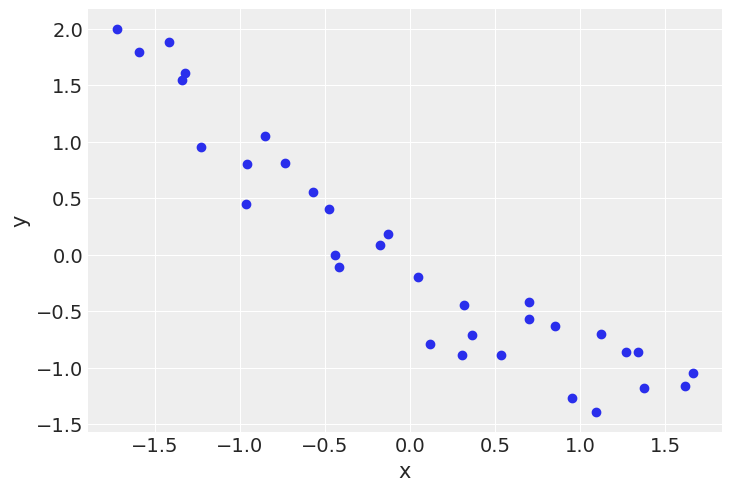

In [65]:
x_1p, x_1s, y_1s = get_data(order=5)
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

Now, we create the model

In [96]:
def get_model_data(order, beta_sd=10):
    with pm.Model() as model_p:
        α = pm.Normal('α', mu=0, sd=1)
        β = pm.Normal('β', mu=0, sd=beta_sd, shape=order)
        ε = pm.HalfNormal('ε', 5)
        μ = α + pm.math.dot(β, x_1s)
        y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y_1s)
        idata_p = pm.sample(2000, return_inferencedata=True)
    return model_p, y_pred, idata_p

In [67]:
model_p, y_pred, idata_p = get_model_data(order=5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 177 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Now, we draw the regression of order 5

In [97]:
def draw_graph(idata_p, order):
    α_p_post = idata_p.posterior['α'].mean(("chain", "draw")).values
    β_p_post = idata_p.posterior['β'].mean(("chain", "draw")).values
    idx = np.argsort(x_1s[0])
    y_p_post = α_p_post + np.dot(β_p_post, x_1s)
    plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')
    plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
    plt.legend()

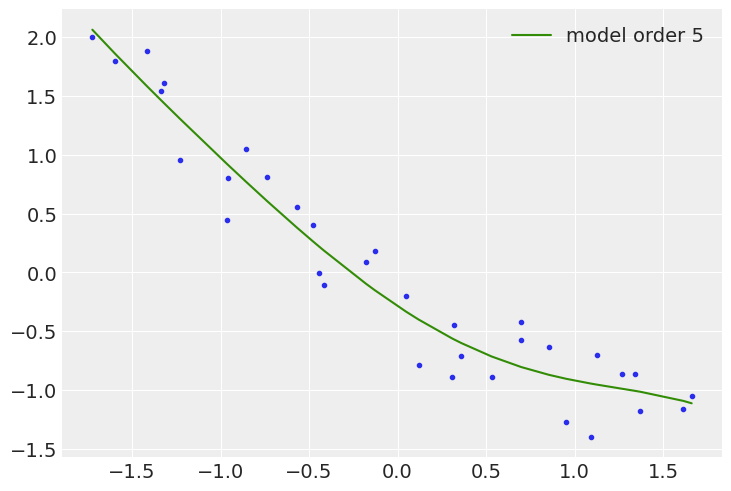

In [69]:
draw_graph(idata_p, order=5)

Get the model with beta sd = 100

In [71]:
model_pb, y_predb, idata_pb = get_model_data(order=5, beta_sd=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 227 seconds.
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8856327652592105, but should be close to 0.8. Try to increase the number of tuning steps.
There were 259 divergences after tuning. Increase `target_accept` or reparameterize.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Draw the regression line coressponding to the model with beta sd = 100

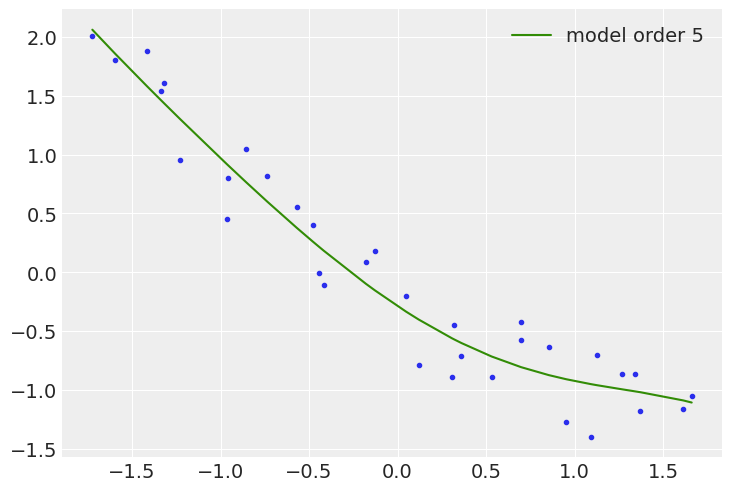

In [72]:
draw_graph(idata_pb, order=5)

Get the model with beta sd = np.array([10, 0.1, 0.1, 0.1, 0.1]) and print the regression line

In [73]:
model_pbb, y_predbb, idata_pbb = get_model_data(order=5, beta_sd=np.array([10, 0.1, 0.1, 0.1, 0.1]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


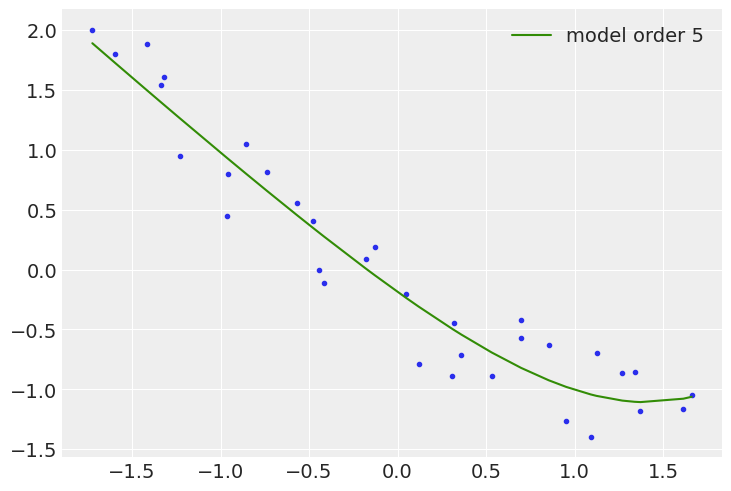

In [74]:
draw_graph(idata_pbb, order=5)

As we can see, the first 2 models generate practically the same curve. However, the last model has a curve that's higher than the other ones, having a smaller accuracy.

Now we try to see how big our dataset is.

In [75]:
print(len(y_1s))

33


Now, we need to increase our dataset to 500 instances. We will generate an increasing sequence of numbers from the min to the max of x and y. With a small step. Then, we will choose randomly the needed number of instances.

In [130]:
min_x = x_1.min() - 1
max_x = x_1.max() + 1
min_y = y_1.min() - 1
max_y = y_1.max() + 1
new_data_size = 500-len(y_1s)

x_1_gen = np.random.choice(np.arange(min_x, max_x, 0.001, dtype=float), 500-len(y_1))
y_1_gen = np.random.choice(np.arange(min_y, max_y, 0.001, dtype=float), 500-len(y_1))

In [131]:
x_big = np.concatenate((x_1, x_1_gen))
y_big = np.concatenate((y_1, y_1_gen))

Standardise the new data

In [132]:
x_big_p = np.vstack([x_big**i for i in range(1, 6)])
x_big_s = (x_big_p - x_big_p.mean()) / x_big_p.std()
y_big_s = (y_big - y_big.mean()) / y_big.std()

Repeat ex 1 with this new data

In [114]:
def get_model_data2(order, beta_sd=10):
    with pm.Model() as model_p:
        α = pm.Normal('α', mu=0, sd=1)
        β = pm.Normal('β', mu=0, sd=beta_sd, shape=order)
        ε = pm.HalfNormal('ε', 5)
        μ = α + pm.math.dot(β, x_big_s)
        y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y_big_s)
        idata_p = pm.sample(2000, return_inferencedata=True)
    return model_p, y_pred, idata_p

In [117]:
def draw_graph2(idata_p, order, it):
    α_p_post = idata_p.posterior['α'].mean(("chain", "draw")).values
    β_p_post = idata_p.posterior['β'].mean(("chain", "draw")).values
    idx = np.argsort(x_big_s[0])
    y_p_post = α_p_post + np.dot(β_p_post, x_big_s)
    plt.plot(x_big_s[0][idx], y_p_post[idx], 'C2', label=f'model order {order} with model nr {it}')
    plt.scatter(x_big_s[0], y_big_s, c='C0', marker='.')
    plt.legend()

In [133]:
model_p2, y_pred2, idata_p2 = get_model_data2(order=5)
model_pb2, y_predb2, idata_pb2 = get_model_data2(order=5, beta_sd=100)
model_pbb2, y_predbb2, idata_pbb2 = get_model_data2(order=5, beta_sd=np.array([10, 0.1, 0.1, 0.1, 0.1]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 113 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 223 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 52 seconds.


Now, we will draw the regression curves for the obtained models

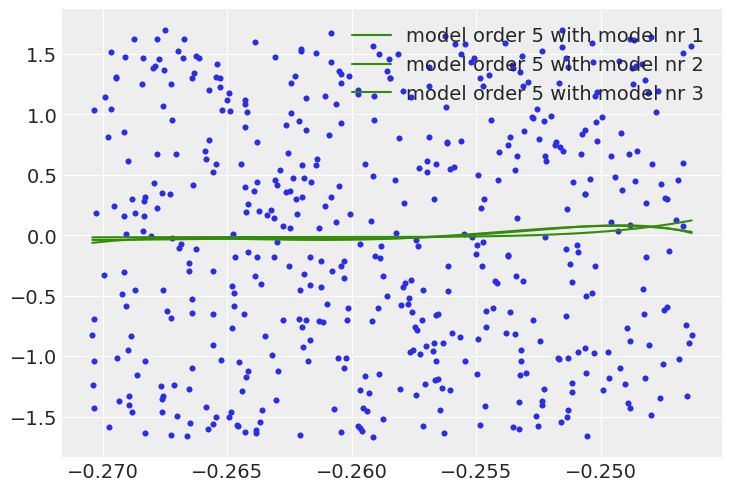

In [134]:
draw_graph2(idata_p2, order=5, it=1)
draw_graph2(idata_pb2, order=5, it=2)
draw_graph2(idata_pbb2, order=5, it=3)

Now we will create a cubic, squared and linear regression model for the new data

In [135]:
x_big_p = np.vstack([x_big**i for i in range(1, 4)])
x_big_s = (x_big_p - x_big_p.mean()) / x_big_p.std()

model_p3, y_pred3, idata_p3 = get_model_data2(order=3)

x_big_p = np.vstack([x_big**i for i in range(1, 3)])
x_big_s = (x_big_p - x_big_p.mean()) / x_big_p.std()

model_p22, y_pred22, idata_p22 = get_model_data2(order=2)

x_big_p = np.vstack([x_big**i for i in range(1, 2)])
x_big_s = (x_big_p - x_big_p.mean()) / x_big_p.std()

model_p1, y_pred1, idata_p1 = get_model_data2(order=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ε, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [121]:
cmp_df = az.compare({'model_l': idata_p3, 'model_p':idata_p22, 'model_c':idata_p1}, method='BB-pseudo-BMA', ic="waic", scale="deviance")
cmp_df

InvalidIndexError: slice(None, None, None)